1. DW KONKURS
2. https://dataworkshop.eu/
3. https://www.kaggle.com/c/carprice/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

In [2]:
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import cross_val_score,KFold,StratifiedKFold
from sklearn.metrics import mean_absolute_error

import scikitplot as skplt

from datetime import datetime

import xgboost as xgb

import lightgbm as lgb

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials


In [3]:
train = pd.read_hdf(r'C:\Users\Seba\Documents\python\datasets-pyth\carprice\train.car_price.h5')
test = pd.read_hdf(r'C:\Users\Seba\Documents\python\datasets-pyth\carprice\test.car_price.h5')

In [4]:
train.head()

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,...,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id
0,"[Osobowe, Dacia, Logan, Dacia Logan II (2012-)]","13:23, 5 marca 2018",PLN,Cena Brutto,45100.0,"Krasne 7A - 36-007 Krasne, rzeszowski, Podkarp...",AUTO SPEKTRUM,Dealer,False,False,...,None,Nowe,II (2012-),None,None,None,Tak,None,None,0
2,"[Osobowe, Peugeot, 3008, Peugeot 3008 I (2009-...","15:48, 5 marca 2018",PLN,"Cena Brutto, Do negocjacji, Faktura VAT",28000.0,"Tomaszów Mazowiecki, tomaszowski, Łódzkie",None,Osoba prywatna,False,False,...,None,Używane,I (2009-2016),None,None,None,Tak,None,None,2
3,"[Osobowe, Porsche, Cayenne, Porsche Cayenne II...","06:30, 4 marca 2018",PLN,"Cena Netto, Do negocjacji, Faktura VAT",229500.0,"Kępińska 24a - 63-640 Bralin, kępiński, Wielko...",P.W. GRIB,Dealer,True,True,...,None,Używane,II (2010-),None,None,None,None,None,None,3
4,"[Osobowe, Peugeot, 308, Peugeot 308 T7 (2008-2...","08:46, 3 marca 2018",PLN,"Cena Brutto, Do negocjacji",19500.0,"Limanowa, limanowski, Małopolskie",None,Osoba prywatna,False,False,...,None,Używane,T7 (2008-2013),None,None,None,Tak,None,None,4
5,"[Osobowe, Volkswagen, Golf, Volkswagen Golf VI...","20:00, 3 marca 2018",PLN,"Cena Brutto, Faktura VAT",164900.0,"Niciarniana 51/53 - 92-320 Łódź, Śródmieście (...",KROTOSKI-CICHY Niciarniana 51/53 oraz Dąbrowsk...,Dealer,True,True,...,None,Używane,VII (2012-),None,None,None,Tak,None,None,5


# SOME VISUALISATION

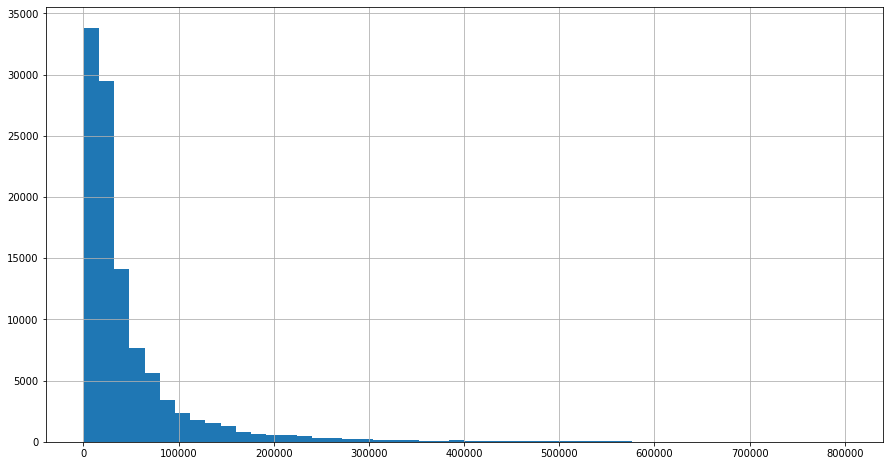

In [304]:
train['price_value'].hist(bins=50,figsize=(15,8))

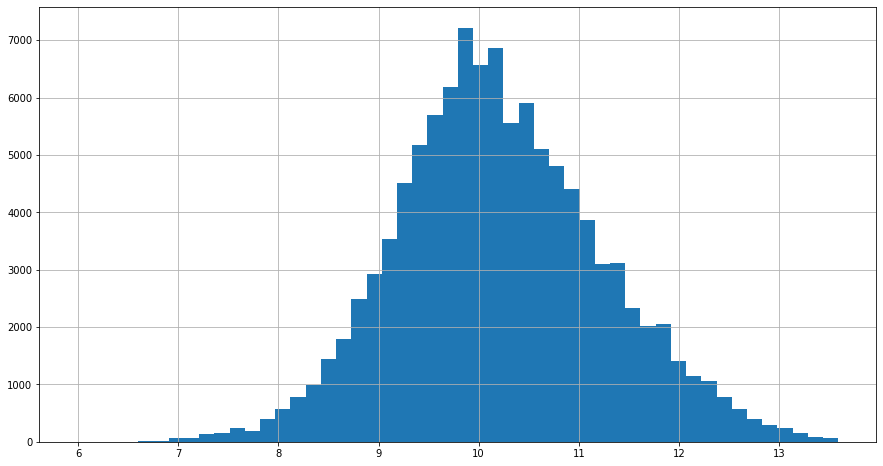

In [305]:
np.log(train['price_value']).hist(bins=50,figsize=(15,8))

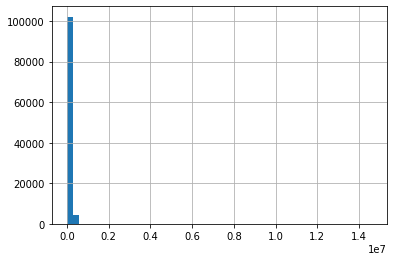

In [389]:
train['param_przebieg'] = train['param_przebieg'].apply(lambda x: str(x).replace('km','').replace(' ','')).apply(lambda x: int(x))
train['param_przebieg'].hist(bins=50)

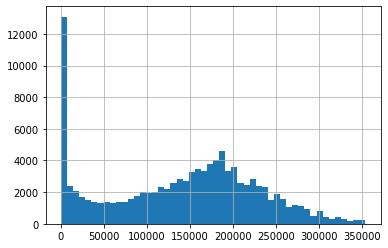

In [397]:
train[train['param_przebieg']< np.percentile(train['param_przebieg'],99)]['param_przebieg'].hist(bins=50)

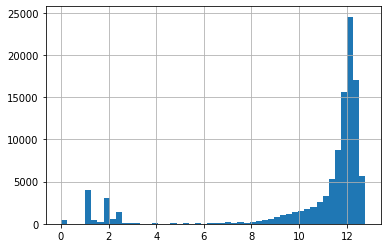

In [404]:
np.log(train[train['param_przebieg']< np.percentile(train['param_przebieg'],99)]['param_przebieg']+2).hist(bins=50)

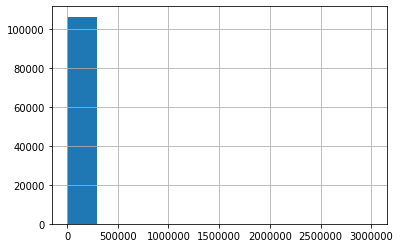

In [406]:
train['param_pojemność-skokowa']= train['param_pojemność-skokowa'].apply(lambda x: int(str(x).split(' c')[0].replace(' ','')))
train['param_pojemność-skokowa'].hist()

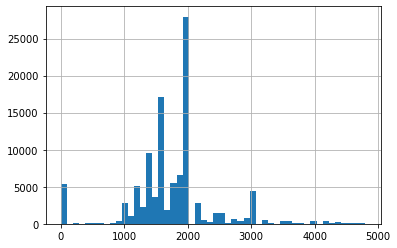

In [407]:
train[train['param_pojemność-skokowa']< np.percentile(train['param_pojemność-skokowa'],99)]['param_pojemność-skokowa'].hist(bins=50)

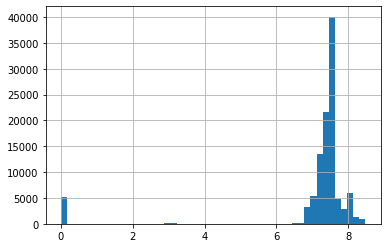

In [408]:
np.log(train[train['param_pojemność-skokowa']< np.percentile(train['param_pojemność-skokowa'],99)]['param_pojemność-skokowa']+2).hist(bins=50)

# BASIC MODEL

In [5]:
def get_feats(df):
    feats = df.select_dtypes(include=[np.number, np.bool]).columns
    return [feat for feat in feats if feat not in ['price_value','car_id'] ]


def run_cv(model,df, cv=5):
    feats = get_feats(df)
    X = df[feats].values
    y = df['price_value'].values

    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    scores = np.abs(scores)

    skplt.estimators.plot_learning_curve(model, X, y, title='Learning Curve',figsize=(15, 5), cv=cv, scoring='neg_mean_absolute_error')
    return np.mean(scores), np.std(scores)


def run_cv_log(model,df, folds=5):
    feats = get_feats(train)
    X = df[feats].values
    y = df['price_value'].values
    y_log = np.log(y)
    
    cv = KFold(n_splits=folds, shuffle=True, random_state=2018)
    
    scores = []
    for train_idx, test_idx in cv.split(X):
        model.fit(X[train_idx], y_log[train_idx])
        y_log_pred = model.predict(X[test_idx])
        
        y_pred = np.exp(y_log_pred)
        y_pred[ y_pred < 400 ] = 400 #global minimum
        
        score = mean_absolute_error(y[test_idx], y_pred)
        scores.append(score)
    
    skplt.estimators.plot_learning_curve(model, X, y, title='Learning Curve',figsize=(15, 5), cv=cv, scoring='neg_mean_absolute_error')
    return np.mean(scores), np.std(scores)

(39466.82449995886, 239.47226744300139)

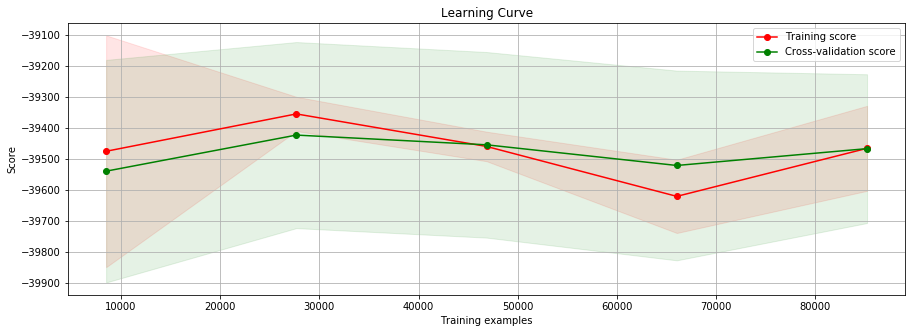

In [8]:
run_cv(DummyRegressor())

Wall time: 4min 26s


(22317.19206519717, 192.93369724969622)

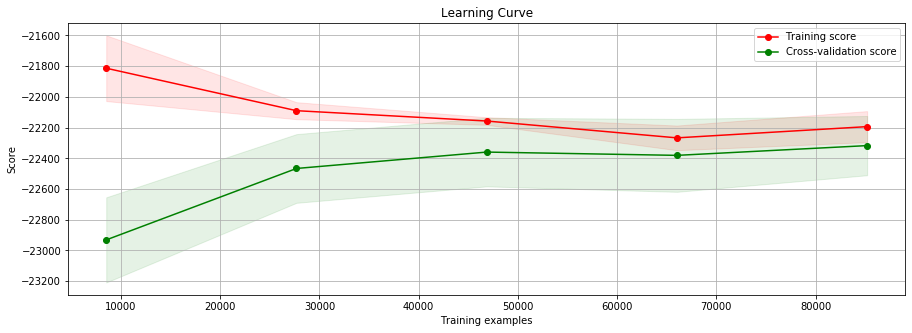

In [437]:
%%time
run_cv(xgb.XGBRegressor(objective='reg:squarederror'),train)

Wall time: 47 s


(20662.159997226725, 156.56216611761417)

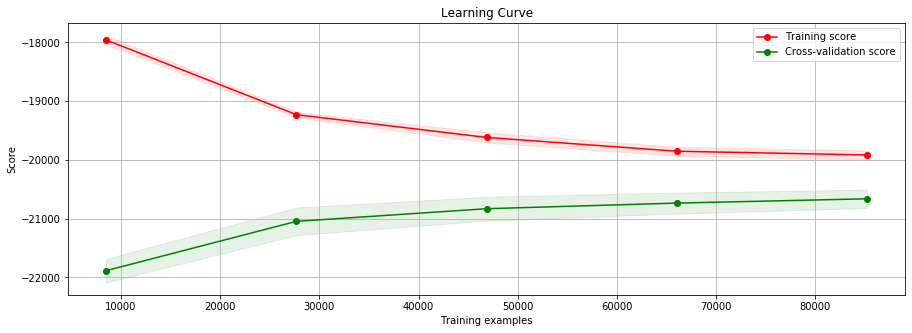

In [169]:
%%time
run_cv(lgb.LGBMRegressor(silent=True),train)

In [6]:
def feature_engineering(df):
    # fill na values
    df_modified = df.fillna(-1)
    
    df_modified['price_currency'] = df_modified['price_currency'].factorize()[0]
    
    #factorize all bolleans
    for x in df.select_dtypes([np.bool]).columns:
        df_modified[x] = df_modified[x].factorize()[0]
    

    df_modified['cena brutto'] = df['price_details'].map(lambda x: 1 if 'cena brutto' in str(x) or 'brutto' in str(x) or 'gross' in str(x) else 0)
    df_modified['cena netto'] = df['price_details'].map(lambda x: 1 if 'cena netto' in str(x) or 'netto' in str(x) else 0)
    df_modified['do_negocjacji'] = df['price_details'].map(lambda x: 1 if 'do negocjacji' in str(x) else 0)
    df_modified['faktura_vat'] = df['price_details'].map(lambda x: 1 if 'faktura vat' in str(x) else 0)
    df_modified.drop('price_details',axis=1,inplace=True)
    
    #seller adress
    
    df_modified['seller_type'] = df_modified['seller_type'].apply(lambda x: 'None' if x == -1 else x)
    st_dict = {'Dealer': 0, 
               'Osoba prywatna' : 1,
               'None' : -1}
    df_modified['seller_type'] = df_modified['seller_type'].map(st_dict)
    
    df_modified['param_uszkodzony'] = df_modified['param_uszkodzony'].apply(lambda x: 1 if x =='Tak' else 0)
    
    df_modified['param_marka-pojazdu'] = df_modified['param_marka-pojazdu'].factorize()[0]
    
    df_modified['param_liczba-drzwi'] = df_modified['param_liczba-drzwi'].apply(lambda x: 6 if int(x)>6 else int(x)).factorize()[0]
    
    df_modified['param_przebieg'] = df_modified['param_przebieg'].apply(lambda x: str(x).replace('km','').replace(' ','')).apply(lambda x: int(x))
    df_modified['param_przebieg'] = np.log(df_modified['param_przebieg']+2)

    
    df_modified['param_rok-produkcji'] = df_modified['param_rok-produkcji'].factorize()[0]
    
    df_modified['param_napęd'] = df_modified['param_napęd'].apply(lambda x: '4x4' if '4x4' in str(x) else str(x))
    df_modified['param_napęd'] = df_modified['param_napęd'].factorize()[0]
    
    typ = ['Kombi','Sedan','Kompakt','SUV','Auta miejskie','Minivan','Auta małe','Coupe']
    df_modified['param_typ'] = df_modified['param_typ'].apply(lambda x: x if x in typ else 'other')
    df_modified['param_typ'] = df_modified['param_typ'].factorize()[0]
    
    df_modified['param_skrzynia-biegów'] = df_modified['param_skrzynia-biegów'].apply(lambda x: 'Automatyczna/Półautomatyczna' if 'automatyczna' in str(x).lower() else x)
    df_modified['param_skrzynia-biegów'] = df_modified['param_skrzynia-biegów'].factorize()[0]
    
    df_modified['param_oferta-od'] = df_modified['param_oferta-od'].factorize()[0]
    
    df_modified['param_moc'] = df_modified['param_moc'].apply(lambda x: str(x).replace('KM','').replace(' ',''))
    df_modified['param_moc'] = df_modified['param_moc'].apply(lambda x: int(x))
    df_modified['param_moc'] = np.log(df_modified['param_moc']+2)

    
    df_modified['param_kraj-pochodzenia'] = df_modified['param_kraj-pochodzenia'].factorize()[0]
    
    df_modified['param_rodzaj-paliwa'] = df_modified['param_rodzaj-paliwa'].apply(lambda x: 'other' if x not in ['Diesel','Benzyna','Benzyna+LPG'] else x )
    df_modified['param_rodzaj-paliwa'] = df_modified['param_rodzaj-paliwa'].factorize()[0]
    
    df_modified['param_model-pojazdu'] = df_modified['param_model-pojazdu'].factorize()[0]
    
    
    
    df_modified['param_stan'] = df_modified['param_stan'].factorize()[0]
    
    df_modified['param_pojemność-skokowa']= df_modified['param_pojemność-skokowa'].apply(lambda x: int(str(x).split(' c')[0].replace(' ','')))
    df_modified['param_pojemność-skokowa'] = np.log(df_modified['param_pojemność-skokowa']+2)
    
    #parametry które nie polepszają modelu, ale zostały przetestowane
    #df_modified['bezwypadkowy'] = df_modified['param_bezwypadkowy'].map(lambda x: 1 if x=='Tak' else 0) 
    #df_modified['param_pierwszy-właściciel'] = df_modified['param_pierwszy-właściciel'].factorize()[0]
    #df_modified['param_kolor'] = df_modified['param_kolor'].factorize()[0]
    #df_modified['miasto'] = df_modified['miasto'].factorize()[0]
    #df_modified['wojewodztwo'] = df_modified['wojewodztwo'].factorize()[0]
    
    

    
    
    return df_modified

X_train_mod = feature_engineering(train)

In [81]:
for column in train.columns:
    print(column)
    print('')
    print(train[column].value_counts(normalize=True))
    print('')

breadcrumb

[Osobowe, Opel, Astra, Opel Astra H (2004-2014)]                   0.013419
[Osobowe, Opel, Insignia, Opel Insignia A (2008-2017)]             0.010949
[Osobowe, Opel, Astra, Opel Astra J (2009-2015)]                   0.009803
[Osobowe, Ford, Focus, Ford Focus Mk3 (2010-)]                     0.008564
[Osobowe, Volkswagen, Passat, Volkswagen Passat B6 (2005-2010)]    0.008517
                                                                     ...   
[Osobowe, Daewoo, MUSSO]                                           0.000009
[Osobowe, BMW, BMW-1M]                                             0.000009
[Osobowe, Lada, 2106]                                              0.000009
[Osobowe, Opel, Inny]                                              0.000009
[Osobowe, Volvo, 340]                                              0.000009
Name: breadcrumb, Length: 2003, dtype: float64

created_at

12:13, 2 marca 2018      0.001230
12:17, 2 marca 2018      0.001127
-1                      

Name: feature_światła-przeciwmgielne, dtype: float64

feature_ogrzewanie-postojowe

False    0.967632
True     0.032368
Name: feature_ogrzewanie-postojowe, dtype: float64

feature_radio-niefabryczne

False    0.93502
True     0.06498
Name: feature_radio-niefabryczne, dtype: float64

feature_regulowane-zawieszenie

False    0.959162
True     0.040838
Name: feature_regulowane-zawieszenie, dtype: float64

feature_ogranicznik-prędkości

False    0.838592
True     0.161408
Name: feature_ogranicznik-prędkości, dtype: float64

feature_zmieniarka-cd

False    0.908342
True     0.091658
Name: feature_zmieniarka-cd, dtype: float64

feature_szyberdach

False    0.911094
True     0.088906
Name: feature_szyberdach, dtype: float64

feature_isofix

True     0.530866
False    0.469134
Name: feature_isofix, dtype: float64

feature_asystent-pasa-ruchu

False    0.931517
True     0.068483
Name: feature_asystent-pasa-ruchu, dtype: float64

feature_alufelgi

True     0.636449
False    0.363551
Name: featur

Name: param_liczba-drzwi, dtype: float64

param_first-registration

-1                   0.999709
16 January 2017      0.000009
04 October 2017      0.000009
30 December 2013     0.000009
2 July 2005          0.000009
26 October 2010      0.000009
04 December 2012     0.000009
24 February 2009     0.000009
25 May 2017          0.000009
16 July 2004         0.000009
8 January 2004       0.000009
26 June 2008         0.000009
26 November 2004     0.000009
18 May 2017          0.000009
1 February 2016      0.000009
1 January 2010       0.000009
16 May 2017          0.000009
17 September 2010    0.000009
19 February 2010     0.000009
07 May 2014          0.000009
26 February 2014     0.000009
24 October 2016      0.000009
15 May 2007          0.000009
12 July 2011         0.000009
9 August 2012        0.000009
23 September 2013    0.000009
19 October 2007      0.000009
1 September 1997     0.000009
24 June 2009         0.000009
2 February 2004      0.000009
12 June 2014         0.000009
09

Name: param_door-count, dtype: float64

param_tuning

-1     0.994526
Tak    0.005474
Name: param_tuning, dtype: float64

param_filtr-cząstek-stałych

-1     0.941086
Tak    0.058914
Name: param_filtr-cząstek-stałych, dtype: float64

param_nr-of-seats

-1    0.999324
5     0.000629
4     0.000028
7     0.000019
Name: param_nr-of-seats, dtype: float64

param_kolor

Czarny        0.243525
Srebrny       0.183935
Szary         0.136487
Biały         0.109706
Niebieski     0.108757
Inny kolor    0.071619
Czerwony      0.038425
Brązowy       0.026894
Zielony       0.024245
Bordowy       0.017729
Złoty         0.015212
Beżowy        0.013231
Fioletowy     0.004695
Żółty         0.003737
-1            0.001803
Name: param_kolor, dtype: float64

param_engine-capacity

-1           0.999258
1 600 cm3    0.000169
1 995 cm3    0.000056
2 000 cm3    0.000047
1 968 cm3    0.000047
1 998 cm3    0.000028
1 400 cm3    0.000028
1 800 cm3    0.000019
3 000 cm3    0.000019
1 896 cm3    0.000019
1 200 cm3 

In [196]:
def wojewodztwo(text):
    lista_wojewodztw =['dolnośląskie','dolnoslaskie','kujawsko-pomorskie',
            'kujawsko-pomorskie','lubelskie','lubuskie','lubuskie',
            'łódzkie','lodzkie','małopolskie','malopolskie','mazowieckie','opolskie','podkarpackie','podlaskie','pomorskie','śląskie',
            'slaskie','świętokrzyskie','swietokrzyskie','warmińsko-mazurskie','warminsko-mazurskie','wielkopolskie','zachodniopomorskie','pomorskie']
    
    counter= 0
    for woj in lista_wojewodztw:
        if text == -1:
            return -1
        else:
            if woj in text.lower():
                counter +=1
                return woj.lower()
    
    if counter == 0:
        return -1
    
def miasto(text):
    lista_miast = list(df_miasta_wojewodztwa['miasto'])
    counter= 0
    for row in lista_miast:
        if text == -1:
            return -1
        else:
            if row.lower() in text.lower():
                counter +=1
                return row.lower()
    
    if counter == 0:
        return -1

wojewodztwa_dict = {1 :'dolnośląskie',
2:'kujawsko-pomorskie',
3:'lubelskie',
4:'lubuskie',
5:'łódzkie',
6:'małopolskie',
7:'mazowieckie',
8:'opolskie',
9:'podkarpackie',
10:'podlaskie',
11:'pomorskie',
12:'śląskie',
13:'świętokrzyskie',
14:'warmińsko-mazurskie',
15:'wielkopolskie',
16:'zachodniopomorskie'}
 

In [192]:
df_miasta_wojewodztwa = pd.read_csv(r'C:\Users\Seba\Documents\python\datasets-pyth\carprice\places.csv')

In [193]:
df_miasta_wojewodztwa['nr_woj'] = df_miasta_wojewodztwa['woj;miasto'].apply(lambda x: str(x).split(';')[0].lower())
df_miasta_wojewodztwa['miasto'] = df_miasta_wojewodztwa['woj;miasto'].apply(lambda x: str(x).split(';')[1].lower())
df_miasta_wojewodztwa.drop('woj;miasto',axis=1,inplace=True)
df_miasta_wojewodztwa['wojewodztwo'] = df_miasta_wojewodztwa['nr_woj'].apply(lambda x: wojewodztwa_dict[int(x)] )

In [194]:
train['wojewodztwo'] = train['seller_address'].apply(lambda x: wojewodztwo(x) )
train['wojewodztwo'].value_counts()

opolskie               16080
mazowieckie            14881
-1                     13861
śląskie                10730
pomorskie               8104
małopolskie             7994
dolnośląskie            6800
łódzkie                 5417
kujawsko-pomorskie      4577
lubelskie               4511
podkarpackie            3612
świętokrzyskie          3325
warmińsko-mazurskie     2616
lubuskie                2570
podlaskie               1416
Name: wojewodztwo, dtype: int64

In [197]:
train['miasto'] = train['seller_address'].apply(lambda x: miasto(x) )
train['miasto'].value_counts()

warszawa            7551
-1                  5887
wrocław             2818
kraków              2463
łódź                2212
                    ... 
głowaczów              1
gorzów śląski          1
międzylesie            1
debrzno                1
lasowice wielkie       1
Name: miasto, Length: 1553, dtype: int64

In [271]:
def najdluzszy_wyraz(x):
    for elem in x:
        if len(elem)> 5:
            return elem

def uzupelnianie_wojewodztw(text):
    lista_miast = list(df_miasta['miasto'])
    counter= 0
    for row in lista_miast:
        if text == -1:
            return -1
        else:
            if row.lower() in text.lower():
                counter +=1
                a = najdluzszy_wyraz(df_miasta_wojewodztwa[df_miasta_wojewodztwa['miasto']==row.lower()]['wojewodztwo'].to_string().split(' '))
                return a 

In [283]:
my_indexes = list(train[(train['wojewodztwo']== -1)&(train['miasto']!= -1) ]['wojewodztwo'].index)

In [293]:
train.loc[my_indexes,'wojewodztwo'] = train[(train['wojewodztwo']== -1)&(train['miasto']!= -1) ]['seller_address'].apply(lambda x: uzupelnianie_wojewodztw(x))

In [296]:
train['wojewodztwo'].value_counts()

mazowieckie                 20819
opolskie                    16126
śląskie                     11869
małopolskie                  9021
pomorskie                    8914
dolnośląskie                 8125
łódzkie                      6399
kujawsko-pomorskie           5117
lubelskie                    4654
podkarpackie                 3633
świętokrzyskie               3325
lubuskie                     3014
warmińsko-mazurskie          2830
podlaskie                    1775
zachodniopomorskie            415
wielkopolskie                 181
-1                            143
lubelskie\n1752                61
dolnośląskie\n1897             47
lubelskie\n2115                 9
lubelskie\n1376                 6
łódzkie\n1232                   3
kujawsko-pomorskie\n1259        3
lubelskie\n1119                 2
lubelskie\n1222                 2
lubelskie\n1141                 1
Name: wojewodztwo, dtype: int64

Wall time: 1min 2s


(10659.035377063996, 169.47610227890218)

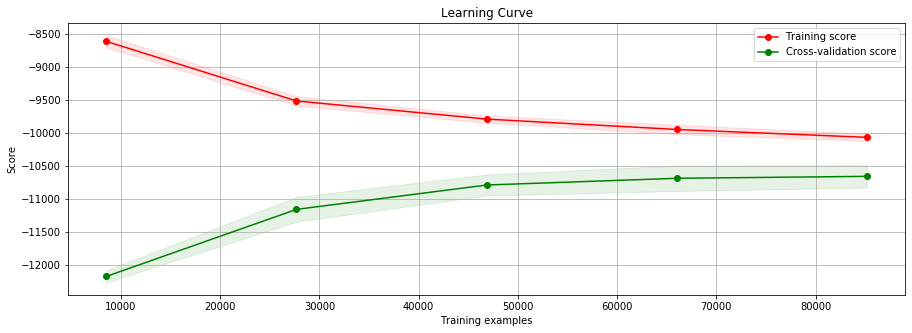

In [323]:
%%time
run_cv(lgb.LGBMRegressor(),X_train_mod)

In [432]:
%%time
def objective(space):
    
    LGBM_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'random_state': int(space['random_state']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100
    }
    
    feats = get_feats(X_train_mod)
    X = X_train_mod[feats].values
    y = X_train_mod['price_value'].values

    model = lgb.LGBMRegressor(**LGBM_params)
    kf = KFold(n_splits=5, random_state=2018, shuffle=True)
    scores= []
    for train_idx, test_idx in kf.split(X):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        score = mean_absolute_error(y[test_idx], y_pred)
        scores.append(score)
    scores = np.mean(scores)
    return{'loss':scores, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=20,
            trials=trials)

print("The best params: ", best_params)


100%|█████████████████████████████████████████████████| 20/20 [03:58<00:00, 11.93s/trial, best loss: 8347.779755002248]
The best params:  {'x_colsample_bytree': 0.9641692268294041, 'x_learning_rate': 0.19979597406960634, 'x_max_depth': 12.0, 'x_min_child_weight': 6.0, 'x_random_state': 7400.0, 'x_reg_alpha': 2.215841985961205, 'x_reg_lambda': 0.9604265888317605, 'x_subsample': 0.7452505670732649}
Wall time: 3min 58s


In [19]:
best_params = {'colsample_bytree': 0.9641692268294041,
               'learning_rate': 0.19979597406960634,
               'max_depth': 12,
               'min_child_weight': 6,
               'random_state': 7400,
               'reg_alpha': 2.215841985961205,
               'reg_lambda': 0.9604265888317605,
               'subsample': 0.7452505670732649,
              'n_estimators': 100}

(8349.38706435533, 110.19377411787197)

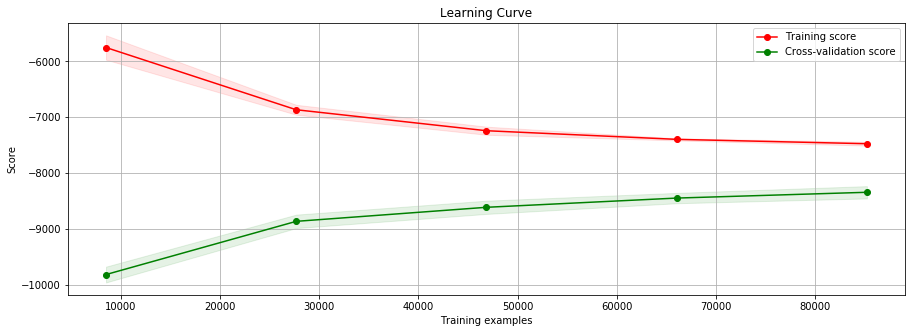

In [20]:
run_cv(lgb.LGBMRegressor(**best_params),X_train_mod)

In [440]:
%%time
def objective(space):
    
    XGB_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'random_state': int(space['random_state']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100,
        'objective' :'reg:squarederror'
    }
    
    feats = get_feats(X_train_mod)
    X = X_train_mod[feats].values
    y = X_train_mod['price_value'].values

    model = xgb.XGBRegressor(**XGB_params)
    kf = KFold(n_splits=5, random_state=2018, shuffle=True)
    scores= []
    for train_idx, test_idx in kf.split(X):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        score = mean_absolute_error(y[test_idx], y_pred)
        scores.append(score)
        final = np.mean(scores)
    
    return{'loss':final, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)

print("The best params: ", best_params)

100%|██████████████████████████████████████████████| 10/10 [1:07:17<00:00, 403.76s/trial, best loss: 7073.878853765287]
The best params:  {'x_colsample_bytree': 0.8047118392951707, 'x_learning_rate': 0.05391018257212816, 'x_max_depth': 20.0, 'x_min_child_weight': 9.0, 'x_random_state': 500.0, 'x_reg_alpha': 1.0075712732869828, 'x_reg_lambda': 0.990131046081423, 'x_subsample': 0.9937653850606979}
Wall time: 1h 7min 17s


In [21]:
# xgb best params
xgb_best_params = {'colsample_bytree': 0.8951311504403153,
                   'learning_rate': 0.14634341083747662,
                   'max_depth': 12,
                   'min_child_weight': 1,
                   'random_state': 4050,
                   'reg_alpha': 1.7896369812428412,
                   'reg_lambda': 0.8413737355335262,
                   'subsample': 0.8559724108178721,
                   'n_estimators': 100,
                  'objective' :'reg:squarederror'}

Wall time: 21min 23s


(7180.910593192925, 77.33011090536075)

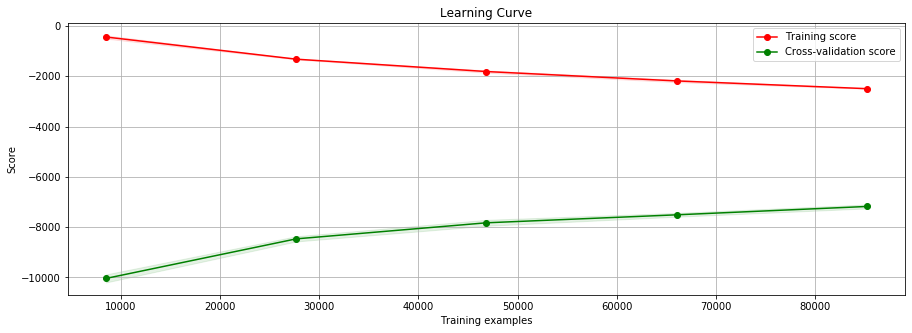

In [22]:
%%time
run_cv(xgb.XGBRegressor(**xgb_best_params),X_train_mod)

Wall time: 40 s


(19051.94913800207, 340.2450786339344)

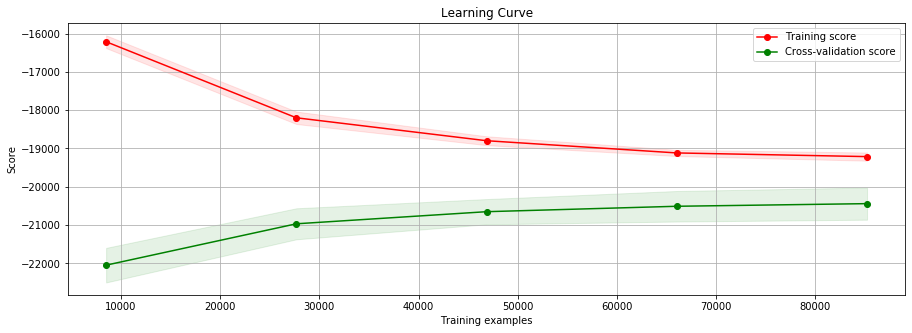

In [23]:
%%time
run_cv_log(lgb.LGBMRegressor(**best_params),X_train_mod)

# Prepare submit

In [77]:

train_test = pd.concat([train,test])
final_df = feature_engineering(train_test)
test_modified = final_df[ final_df['price_value'] == -1]
train_modified = final_df[ final_df['price_value']!= -1]
#train_test[ ~train_test['price_value'].isnull()]

feats = get_feats(train_modified)
X = train_modified[feats].values
y = train_modified['price_value'].values
X_test = test_modified[feats].values

model = lgb.LGBMRegressor(**best_params)
model.fit(X,y)
y_pred = model.predict(X_test)

submit = pd.read_csv(r'C:\Users\Seba\Documents\python\datasets-pyth\carprice\sample.csv')
submit['price_value'] = y_pred
submit.to_csv(r'C:\Users\Seba\submit.csv', index=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.
